<div class="alert alert-success"> 
        <h1 align="center" style="color:chocolate;">Learning Agency Lab</h1>  
     
</div>

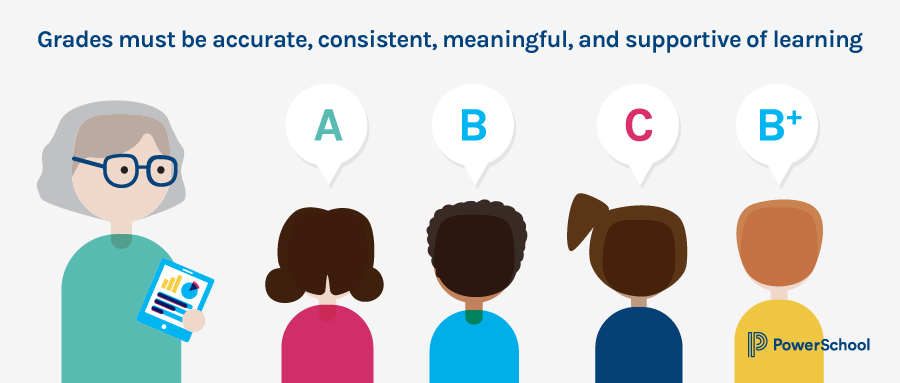

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 About The Competition :</font></h3>
    
**Task**: Predict the holistic score of argumentative essays based on a dataset comprising approximately 24,000 student-written essays. Each essay is scored on a scale of 1 to 6 using a Holistic Scoring Rubric.

**Dataset**: The dataset includes a training set (train.csv) containing essay IDs, full text, and corresponding scores, and a test set (test.csv) with essay IDs and full text. The sample_submission.csv file provides a template for submitting predictions.

**Objective**:  Develop an open-source essay scoring algorithm using the largest open-access writing dataset aligned with current standards for student-appropriate assessments. The goal is to improve upon the original Automated Student Assessment Prize (ASAP) competition hosted in 2012 by producing a more accurate and widely accessible AWE solution.
    
**Exploration**: Explore the distribution of essay scores in the training set to understand the dataset's balance. Conduct preprocessing steps such as tokenization, stopword removal, and text cleaning. Examine potential differences between the provided dataset and previous AWE competitions, ensuring inclusivity and diversity across economic and location populations to mitigate algorithmic bias.

**Evaluation**: Submissions will be evaluated based on their ability to predict the holistic score of essays in the test set. Performance will be assessed using appropriate regression metrics, such as mean squared error (MSE) or mean absolute error (MAE).

**Submission**: Prepare predictions for the holistic scores of essays in the test set in the specified format (sample_submission.csv). Aim to develop a robust essay scoring algorithm that provides accurate predictions and contributes to improving educational tools for students and educators, particularly in underserved districts.

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Importing Libraries</h1>  
     
</div>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tokenizers import decoders, models,normalizers,pre_tokenizers,processors,trainers,Tokenizer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:150%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡Reading The Data :</font></h3>

In [ ]:
df_train = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
df_test = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
df_sub = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv')

In [ ]:
df_train.shape

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:150%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡Display basic information about the DataFrames :</font></h3>

In [ ]:
print("Training Essays Info:")
print(df_train.info())

print("\nTest Essays Info:")
print(df_test.info())



print("\nSample Submission Info:")
print(df_sub.info())

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #F08080; font-size:100%; text-align:left">

<h3 align="center"><font color='#000000'>💡Categorical Columns:</font></h3>
    
🎡🎠🎁From Above we can see the dataset is a combination of float and object types,
    
    The Train dataset has over 17307  entries whereas for test and submission we dun have much entries, more information cn be seen 
    in the above data section

🎪🎁🎇Lets Begin the Journey 🎏✨🧨

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #92a8d1; font-size:150%; text-align:center">

<h3 align="centre"><font color='#fefbd8'>💡Plotting The Data:</font></h3>
    
🎁As some of the Dataset are categorical in nature🎨🧨
    
 🕶👓Lets Check out some plot and what they got to say about it
    
We are going to use wordcloud in the word cloud, words are typically presented in a random arrangement, and their sizes are proportional to their frequency or importance. Frequently occurring words are usually displayed with larger fonts or sizes, while less common words appear smaller.
    
It can help identify patterns, key terms, or trends within a large body of text.

In [ ]:
from wordcloud import WordCloud

text_data = ' '.join(df_train['full_text'])


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)


plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of text')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 Observation from above plot :</font></h3>
    
WIP


In [ ]:

sns.countplot(x='score', data=df_train)
plt.title('Distribution of Score')
plt.xlabel('Generated')
plt.ylabel('Count')

for idx, value in enumerate(df_train['score'].value_counts()):
    plt.text(idx, value, str(value), ha='center', va='bottom')

plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 Target Dataset :</font></h3>
    
  

In [ ]:
df_train['text_char_count'] = df_train['full_text'].apply(lambda x: len(str(x)))
sns.histplot(df_train['text_char_count'], bins=30, kde=True)
plt.title('Distribution of Essay Character Counts')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams_barchart(text, n=2, top=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top]
    words, freq = zip(*words_freq)
    plt.bar(words, freq)
    plt.xlabel(f'{n}-grams')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Frequency')
    plt.title(f'Top {top} {n}-grams in Essays')
    plt.show()


plot_top_ngrams_barchart(df_train['full_text'], n=2)


plot_top_ngrams_barchart(df_train['full_text'], n=3)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_train['full_text'])


lda = LatentDirichletAllocation(n_components=5, random_state=42)
topics = lda.fit_transform(tfidf_matrix)

feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_keywords_idx = topic.argsort()[:-10 - 1:-1]
    top_keywords = [feature_names[idx] for idx in top_keywords_idx]
    print(f"Topic #{i + 1}: {', '.join(top_keywords)}")


In [ ]:
from wordcloud import STOPWORDS

common_stopwords = set(STOPWORDS)
wc_stopwords = WordCloud(stopwords=common_stopwords, width=900, height=400, max_words=200, background_color='white').generate(' '.join(df_train['full_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wc_stopwords, interpolation='bilinear')
plt.title('Word Cloud with Common Stop Words Removed')
plt.axis('off')
plt.show()

In [ ]:
from collections import Counter


words = ' '.join(df_train['full_text']).split()
word_counts = Counter(words)


top_words = word_counts.most_common(20)
plt.bar(*zip(*top_words))
plt.title('Top 20 Most Common Words in Essays')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
import spacy
from spacy import displacy


nlp = spacy.load("en_core_web_sm")

sample_essay = df_train['full_text'].iloc[0]
doc = nlp(sample_essay)
displacy.render(doc, style="ent", jupyter=True)


In [ ]:
df_train.head(20)

In [ ]:
train = df_train
train = train.drop_duplicates(subset=['full_text'])
train.reset_index(drop=True, inplace=True)

In [ ]:

LOWERCASE = False
VOCAB_SIZE = 30522


raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)
dataset = Dataset.from_pandas(df_test[['full_text']])

In [ ]:
def train_corp_iter():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["full_text"]

raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [ ]:
tokenized_texts_test = []
for text in tqdm(df_test['full_text'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))

In [ ]:
tokenized_texts_train = []
for text in tqdm(train['full_text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

In [ ]:
def dummy(text):
    return text

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer='word',
                             tokenizer=dummy, preprocessor=dummy, token_pattern=None, strip_accents='unicode')

vectorizer.fit(tokenized_texts_test)

vocab = vectorizer.vocabulary_

vocab

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer='word', tokenizer=dummy, preprocessor=dummy, token_pattern=None,
                            strip_accents='unicode')

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

In [ ]:
import gensim

combined_texts = tokenized_texts_train + tokenized_texts_test
word2vec_model = gensim.models.Word2Vec(sentences=combined_texts, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
def generate_doc_vectors(tokenized_texts, model):
    vectors = []
    for text in tokenized_texts:
        text_vector = np.mean([model.wv[word] for word in text if word in model.wv], axis=0)
        vectors.append(text_vector)
    return np.vstack(vectors)

In [ ]:
train_doc_vectors = generate_doc_vectors(tokenized_texts_train, word2vec_model)
test_doc_vectors = generate_doc_vectors(tokenized_texts_test, word2vec_model)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_doc_vectors = scaler.fit_transform(train_doc_vectors)
test_doc_vectors = scaler.transform(test_doc_vectors)

In [ ]:
logreg = LogisticRegression(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
svc_classifier = SVC(probability=True, random_state=42)

In [ ]:
ensemble = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf_classifier),
    ('svc', svc_classifier)
], voting='soft', n_jobs=-1)


In [ ]:
y_train = df_train['score'].values
ensemble.fit(train_doc_vectors, y_train)
final_preds = ensemble.predict(test_doc_vectors)
df_sub['score'] = final_preds

In [ ]:
final_preds

In [ ]:
df_sub.to_csv('submission.csv', index=False)

In [ ]:
df_sub.head()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 Work in Progress :</font></h3>
    


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DBA520'>Looking forward for feedback :</font></h3>
    
